<a href="https://colab.research.google.com/github/hislam000/CSC-599.70-Course-Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Intro to Data Science, Fall 2019 @ CCNY
# CSC-599.70-Course-Project
# Final-Project
# Team Member & Name: RentAdvisor (3-Member)

# ABDUR RAFEY
# HASIBUL ISLAM
# DZHONIBEK PARMANKULOV

In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import warnings
%matplotlib inline

In [0]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)
exdf = pd.read_csv('https://data.cityofnewyork.us/resource/43nn-pn8j.csv',index_col=0)
#external dataset from new york open data
#https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j


In [0]:
train_df.sample(5)

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
rental_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7291084,#2,1256671,1,1.0,600.0,2018-06-20 14:06:52,14-31 28 AVENUE,Astoria,11102,40.771757,-73.927645,4006077.0,4005390007,4.0,2013.0,6.7833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2400,0,This beautiful one-bedroom has beautiful cherr...,Astoria,Queens,2,2.0,NaN
7401403,#3D,135256,1,1.0,750.0,2018-07-25 13:18:33,56 NORTH 9 STREET,Brooklyn,11249,40.721056,-73.960381,3425621.0,3023090005,6.0,2018.0,4.3167,0,1,0,1,0,1,1,1,1,1,0,0,0,0,3150,1,"Located in the heart of Williamsburg, 56N9 is ...",Williamsburg,Brooklyn,3D,3.0,D
7145041,#2,165301,2,1.0,850.0,2018-05-03 23:12:23,506 PRESIDENT STREET,Brooklyn,11215,40.677719,-73.986524,3007491.0,3004470026,2.0,1899.0,1.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500,1,Large Light filled 2 bed 1 bath on sweet block...,Gowanus,Brooklyn,2,2.0,NaN
7411129,#1RNN,15763,1,1.0,600.0,2018-07-26 10:18:12,215 AVENUE A,New York,10009,40.730099,-73.980953,1083483.0,1004410033,5.0,1880.0,1.8667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2300,0,Brand New 1BR apt located on 13th Street Ave ...,East Village,Manhattan,1RNN,1.0,RNN
7312189,#1B,643183,1,1.0,750.0,2018-06-27 14:01:08,268 72 STREET,Brooklyn,11209,40.633443,-74.027627,3147298.0,3059070036,3.0,1926.0,2.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1600,0,Apartment Specs:\r\n\r\n-New Hardwood floors\r...,Bay Ridge,Brooklyn,1B,1.0,B


In [0]:
# extract usable features
feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 
    'size_sqft', 'no_fee', 'has_doorman',
    'addr_zip','floor_count',#'has_elevator',#'has_dishwasher',	#'is_furnished',	
    'has_gym','allows_pets',#'has_garage',
    'has_concierge',#'has_pool',#'has_garden',	
    #the reason of commenting out certain feature is because they are increasing mean squared error
]
train_features = train_df[feature_cols] 

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']

In [4]:
# using linear regression method
lreg = LinearRegression()
lreg.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
test_features = test_df[feature_cols] 

# impute missing values with medians
test_features = test_features.fillna(train_features.median(), axis=0)

# construct predictions 
test_df['predicted'] = lreg.predict(test_features)
print("Prediction using Linear Regression train data against Test1:")

print("Mean Squared Error for Test1 using Linear Regression:",mean_squared_error(test_df['rent'], test_df['predicted']))

Prediction using Linear Regression train data against Test1:
Mean Squared Error for Test1 using Linear Regression: 3313817.143868871


In [6]:
rf = RandomForestRegressor()
rf.fit(train_features, train_target)

# construct predictions 
test_df['predicted'] = rf.predict(test_features)
print("Prediction using Random Forest Regressor train data against Test1:")
print("Mean Squared Error for Test1 using Random Forest Regressor:",mean_squared_error(test_df['rent'], test_df['predicted']))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Prediction using Random Forest Regressor train data against Test1:
Mean Squared Error for Test1 using Random Forest Regressor: 1854806.4735305747


In [0]:
#joining training data and test1 data to incredase total training data
master_df = train_df.append(test_df, sort=False)

In [8]:
#setting external data
cols=['dba','zipcode','grade']
trnexdf=exdf[cols].dropna()
print(trnexdf.shape)


(496, 3)


In [9]:
#trnexdf=trnexdf[trnexdf.grade == 'A']
#trnexdf.sort_values(by=['zipcode'])
#trnexdf.zipcode.unique()
#trnexdf.drop_duplicates(subset ="zipcode",keep = False, inplace = True) 
print(master_df.shape)

(14000, 39)


In [10]:
#preparing dataset to join to training data
tempfeat=['addr_zip','description','has_dishwasher']
tempdf=master_df[tempfeat]
tempdf=tempdf.rename(columns={"addr_zip": "rest_zip", "description": "rest_grade", "has_dishwasher": "rest_name"}, errors="raise")

#filling values
for i in range(14000):
         tempdf.iloc[i,1]='U'
         tempdf.iloc[i,2]='Unknown'
tempdf.sample(5)


,rest_zip,rest_grade,rest_name
rental_id,,,
7212049,10024,U,Unknown
7468666,10025,U,Unknown
7368778,11211,U,Unknown
7466563,11102,U,Unknown
7237981,10011,U,Unknown
7321381,11213,U,Unknown
7324390,11374,U,Unknown
7368166,11218,U,Unknown
7295875,11106,U,Unknown


In [0]:
#matching zip codes with restaurant zip code and copying grade and name
#this takes few minutes
#rental records: 14000
#restaurant records: 496
for i in range(14000):
    for j in range(496):
        if tempdf.iloc[i,0]==int(trnexdf.iloc[j,1]):
                    tempdf.iloc[i,1]=trnexdf.iloc[j,2]
                    tempdf.iloc[i,2]=trnexdf.iloc[j,0]
                    break

In [16]:
print("Amount of Rentals that doesn't have restaurant records")
print(tempdf[tempdf.rest_grade == 'U'].shape)

Amount of Rentals that doesn't have restaurant records
(747, 3)


In [18]:
#joining external data with training data
#now we can see restaurants name and grade corresponding to zip code
master_df=master_df.assign(rest_zip=tempdf["rest_zip"])
master_df=master_df.assign(rest_grade=tempdf["rest_grade"])
master_df=master_df.assign(rest_name=tempdf["rest_name"])
print("Find your Favourite Restaurant in your neighborhood")
master_df.sample(5)

Find your Favourite Restaurant in your neighborhood


,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line,predicted,rest_zip,rest_grade,rest_name
rental_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7421326,#4A,34537,2,2.0,1228.0,2018-07-30 12:03:34,345 WEST 14 STREET,New York,10014,40.740898,-74.004402,1013007.0,1007387504,11.0,1960.0,1.9833,1,1,0,0,0,1,0,1,0,1,1,0,0,0,9950,0,"Developed and conceived by DDG, 345meatpacking...",Chelsea,Manhattan,4A,4.0,A,NaN,10014,A,MOUSTACHE RESTAURANT
7398538,#4B,57577,2,2.0,1149.0,2018-07-24 16:50:41,104 WEST 70 STREET,New York,10023,40.776001,-73.980202,1029665.0,1011417501,11.0,1903.0,2.9500,1,1,0,1,0,0,1,0,0,0,0,0,0,0,6750,0,New to market __ large split two bedroom with ...,Upper West Side,Manhattan,4B,4.0,B,NaN,10023,A,PICK-A-BAGEL/DUMPLING ROOM
7137766,#1P,18180889,2,2.0,1800.0,2018-05-02 12:23:12,350 LINCOLN PLACE,Brooklyn,11238,40.673000,-73.964798,3341924.0,3011790027,0.0,NaN,1.8667,0,1,0,1,0,0,0,0,0,0,0,0,1,0,3300,0,MASSIVE 2 BEDROOM 2.5 BATH DUPLEX APARTMENT WI...,Prospect Heights,Brooklyn,1P,1.0,P,NaN,11238,A,ISLAND CZ CAFE
7149391,#6F,18721537,3,1.0,950.0,2018-05-04 23:03:51,420 EAST 102 STREET,New York,10029,40.786430,-73.941498,1083931.0,1016940005,13.0,1973.0,5.8167,0,1,0,1,0,0,1,0,1,0,0,0,0,0,3500,1,Brand New To Market! Huge Upper East 3Bedroom ...,East Harlem,Manhattan,6F,6.0,F,NaN,10029,A,EMPIRE CORNER II
7241941,#5I,87880,0,1.0,482.0,2018-06-05 16:08:43,400 EAST 90 STREET,New York,10128,40.779099,-73.947304,1087460.0,1015697503,23.0,1999.0,8.3833,1,1,0,1,0,1,0,0,1,0,0,0,0,1,2500,0,Available for August 1st Occupancy. This quiet...,Upper East Side,Manhattan,5I,5.0,I,NaN,10128,A,STELLA AND FLY


In [32]:
new_feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 
    'size_sqft', 'no_fee', 'has_doorman',
    'addr_zip','floor_count',	
    'has_gym','allows_pets',
    'has_concierge',
    #'rest_grade' #Error could not convert string to float: 'B'
]
master_features = master_df[new_feature_cols].fillna(master_df[new_feature_cols].median(), axis=0)
master_target = master_df['rent']
#linear regression
#lreg.fit(master_features, master_target)

#Train the model
#Random Forest Regressor
rf.fit(master_features, master_target)

#test3 size
print(submit1_df.shape)

(2000, 38)


In [49]:
#building temporary dataframe to join to test3
tfeat=['addr_zip','description','has_dishwasher']
temp2df=submit1_df[tfeat]
temp2df.sample(5)
print(temp2df.shape)

(2000, 3)


In [50]:
#filling temporary data frame value
for i in range(2000):
         temp2df.iloc[i,1]='U'
         temp2df.iloc[i,2]='Unknown'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [51]:
#renaming column names and validating
temp2df=temp2df.rename(columns={"addr_zip": "rest_zip", "description": "rest_grade", "has_dishwasher": "rest_name"}, errors="raise")
temp2df.sample(5)

,rest_zip,rest_grade,rest_name
rental_id,,,
7484248,10039,U,Unknown
7441153,11365,U,Unknown
7442155,10001,U,Unknown
7441720,10019,U,Unknown
7497190,10024,U,Unknown


In [0]:
#matching test3 zip codes with restaurant zip code and copying grade and name
#this takes few minutes
#rental records: 2000
#restaurant records: 496
for i in range(2000):
    for j in range(496):
        if temp2df.iloc[i,0]==int(trnexdf.iloc[j,1]):
                    temp2df.iloc[i,1]=trnexdf.iloc[j,2]
                    temp2df.iloc[i,2]=trnexdf.iloc[j,0]
                    break

In [54]:
#assigning restaurant table to test3 
submit1_df=submit1_df.assign(rest_zip=temp2df["rest_zip"])
submit1_df=submit1_df.assign(rest_grade=temp2df["rest_grade"])
submit1_df=submit1_df.assign(rest_name=temp2df["rest_name"])

print("Find Your Favourite Restaurant")
submit1_df.sample(5)

Find Your Favourite Restaurant


,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line,rest_zip,rest_grade,rest_name
rental_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7497247,#3,205726,2,1.0,1100.0,2018-08-21 14:59:35,193 6 AVENUE,Brooklyn,11217,40.675873,-73.977331,3019844.0,3009540010,3.0,1920.0,3.8000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,NaN,0,Upper duplex with PRIVATE ROOF DECK! Expansive...,Park Slope,Brooklyn,3,3.0,NaN,11217,A,New China Tung
7508305,#3,271690,1,1.0,850.0,2018-08-24 15:11:45,761 MACON STREET,Brooklyn,11233,40.684593,-73.921091,3040031.0,3014930048,2.0,1899.0,5.5500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0,Just listed is this very nice one bedroom apar...,Bedford-Stuyvesant,Brooklyn,3,3.0,NaN,11233,A,CROWN FRIED CHICKEN
7484248,#32,119050,2,1.0,800.0,2018-08-16 18:16:36,242 BRADHURST AVENUE,New York,10039,40.829027,-73.938636,1060892.0,1020470021,6.0,1910.0,0.5833,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,0,"Renovated 3rd-floor walkup--Bright, renovated,...",Central Harlem,Manhattan,32,NaN,NaN,10039,C,JUMBO'S HAMBURGERS
7511584,#10F,18717808,3,1.0,932.0,2018-08-26 17:39:03,280 1 AVENUE,New York,10009,40.731701,-73.977898,1082870.0,1009720001,0.0,NaN,1.5667,0,1,0,1,0,0,1,0,1,0,0,0,0,0,NaN,1,"OPEN HOUSE this Sunday, November 4th between 2...",Stuyvesant Town/PCV,Manhattan,10F,10.0,F,10009,P,CRIF DOGS / PLEASE DON'T TELL
7491046,#B1,129442,1,1.0,600.0,2018-08-19 13:28:19,20 BROADWAY TERRACE,New York,10040,40.857597,-73.930762,1064118.0,1021700557,4.0,1927.0,2.7000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,1,No Fee!!!!\r\n\r\nGut Renovated 1 Bedroom Apar...,Washington Heights,Manhattan,B1,1.0,B,10040,B,BAKERY MOCANA


In [0]:
#handling missing data
submit1_features = submit1_df[new_feature_cols].fillna(master_df[new_feature_cols].median(), axis=0)


In [0]:
#predict the rent for test3
submit1_df['rent'] = rf.predict(submit1_features)
submit1_df['rent'].to_csv('test3.csv', header=True)
#compare mean squared

In [57]:
submit1_df['rent'].sample(10)

rental_id
7502446    3003.333333
7467976    4452.500000
7477273    3097.700000
7445347    2094.900000
7465903    2469.900000
7438519    2597.000000
7509568    1674.500000
7489822    1900.000000
7444924    3111.000000
7433215    4334.000000
Name: rent, dtype: float64

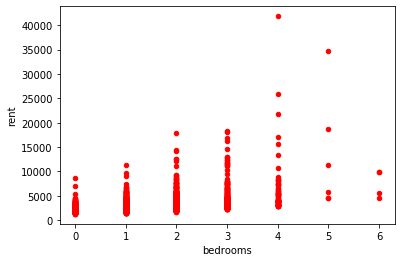

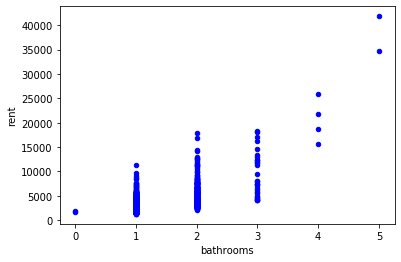

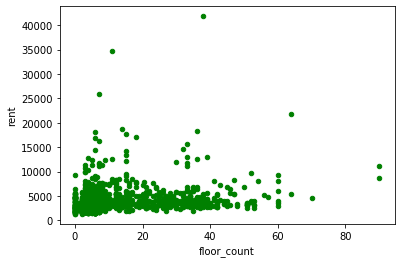

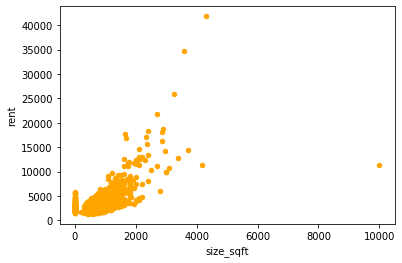

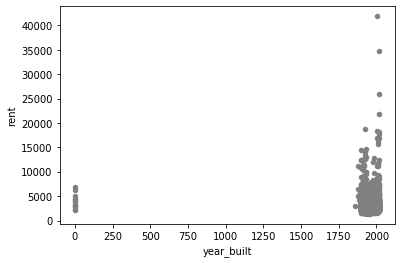

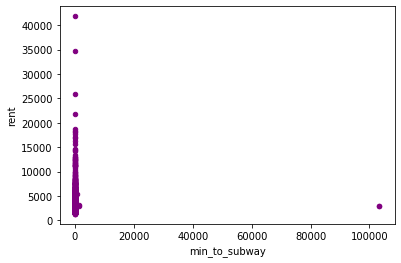

In [58]:
# Scatter plots of different features for test2 data: 

submit1_df.plot(kind='scatter',x='bedrooms',y='rent',color='red')
plt.show()

submit1_df.plot(kind='scatter',x='bathrooms',y='rent',color='blue')
plt.show()

submit1_df.plot(kind='scatter',x='floor_count',y='rent',color='green')
plt.show()

submit1_df.plot(kind='scatter',x='size_sqft',y='rent',color='orange')
plt.show()

submit1_df.plot(kind='scatter',x='year_built',y='rent',color='gray')
plt.show()

submit1_df.plot(kind='scatter',x='min_to_subway',y='rent',color='purple')
plt.show()

#lines = submit1_df.plot.line(x='bedrooms',y='rent')

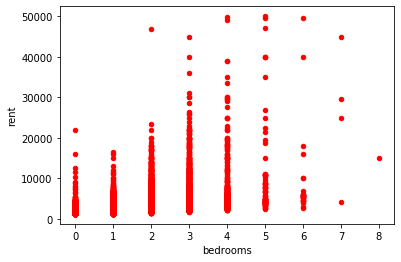

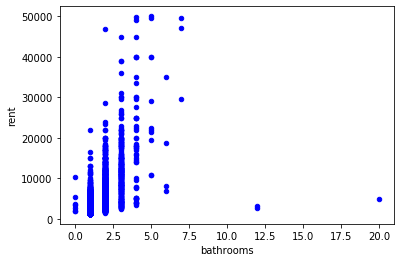

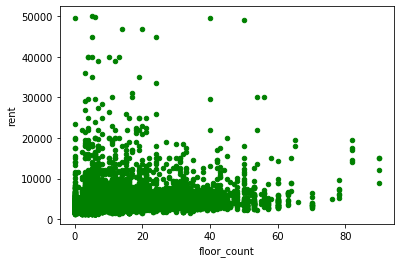

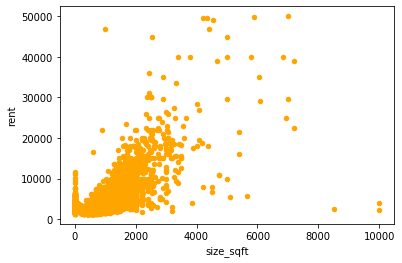

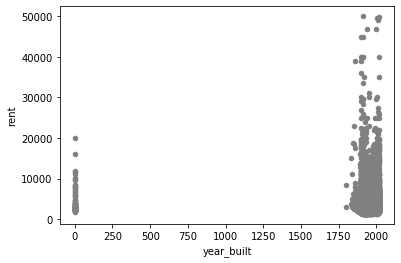

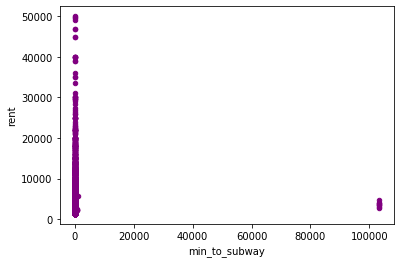

In [59]:
# Scatter plots of different features for training data: 

master_df.plot(kind='scatter',x='bedrooms',y='rent',color='red')
plt.show()

master_df.plot(kind='scatter',x='bathrooms',y='rent',color='blue')
plt.show()

master_df.plot(kind='scatter',x='floor_count',y='rent',color='green')
plt.show()

master_df.plot(kind='scatter',x='size_sqft',y='rent',color='orange')
plt.show()

master_df.plot(kind='scatter',x='year_built',y='rent',color='gray')
plt.show()

master_df.plot(kind='scatter',x='min_to_subway',y='rent',color='purple')
plt.show()




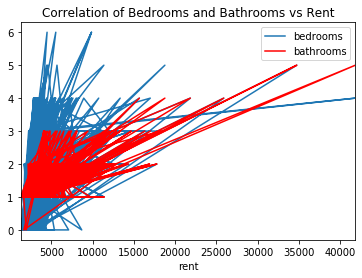

In [60]:
ax = plt.gca()
submit1_df.plot(kind='line',x='rent',y='bedrooms',title='Correlation of Bedrooms and Bathrooms vs Rent',ax=ax)
submit1_df.plot(kind='line',x='rent',y='bathrooms', color='red', ax=ax)
#submit1_df.plot(kind='line',x='rent',y='floornumber', color='green', ax=ax)
plt.show()

In [61]:
#OLS Regression Results for Testing2 Data
# Add a constant to our existing dataframe for modeling purposes
submit1_df = sm.add_constant(submit1_df)

est = sm.OLS(submit1_df['rent'], 
             submit1_features[['bedrooms', 'year_built', 'bathrooms', 'min_to_subway','size_sqft', 'no_fee', 'has_doorman','addr_zip','floor_count','has_gym','allows_pets']]
            ).fit()

print(est.summary())



                                 OLS Regression Results                                
Dep. Variable:                   rent   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              1545.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):                        0.00
Time:                        22:21:12   Log-Likelihood:                         -17228.
No. Observations:                2000   AIC:                                  3.448e+04
Df Residuals:                    1989   BIC:                                  3.454e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [63]:
#OLS Regression Results for Trainin Data
# Add a constant to our existing dataframe for modeling purposes
master_df = sm.add_constant(master_df)

est = sm.OLS(master_df['rent'], 
             master_features[['bedrooms', 'year_built', 'bathrooms', 'min_to_subway','size_sqft', 'no_fee', 'has_doorman','addr_zip','floor_count','has_gym','allows_pets']]
            ).fit()

print(est.summary())


                                 OLS Regression Results                                
Dep. Variable:                   rent   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                              6487.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):                        0.00
Time:                        22:21:22   Log-Likelihood:                     -1.2528e+05
No. Observations:               14000   AIC:                                  2.506e+05
Df Residuals:                   13989   BIC:                                  2.507e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
